# Analisis de variables 

En este cuaderno se explora que variables se tienen, esto con el objetivo de poder identificar modelo que se ajusten a las necesidades de predicción. En primer lugar se hace la carga de datos desde un archivo binario que se obtiene de una petición SQL hecha anteriormente

In [131]:
import pickle5 as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema
from datetime import timedelta
import smtplib
import ssl
import seaborn as sns 
import random 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
filename = "data.ftr"

with open(filename, "rb") as fh:
    data = pickle.load(fh)
    
data = pd.DataFrame(data)

In [10]:
data

,ID_FECHA_CONSULTADA,ANIO_CARTERA,MES_CARTERA,ANIOMES_CARTERA,NUMERO_CONTRATO,TIPO_IDENTIFICACION,IDENTIFICACION,SEXO,INGRESO,REPUTACION_CLIENTE,...,CANTIDAD_FACTURAS_CON_MORA,FECHA_REGISTRO_CARTERA,FECHA_COBRO,FECHA_PAGO,FECHA_RECAUDO,ID_CONTRATO,ID_CLIENTE,ID_GEOGRAFIA,ID_REGION_NATURAL,REGION
0,20181201.0,2018,11,201811,758589809482,5,30567722,F,2454284.0,4.0,...,0.0,2018-11-23,2018-12-08,2018-11-26,2018-11-27,8689.0,3929.0,54670.0,2.0,Centro Oriente
1,20190101.0,2018,12,201812,830910315567,2,11642038,M,5492814.0,5.0,...,0.0,2018-12-23,2019-01-07,2018-12-27,2018-12-28,11372.0,5614.0,54670.0,2.0,Centro Oriente
2,20190101.0,2018,12,201812,915320322651,3,72850794,M,5946697.0,3.0,...,0.0,2018-12-23,2019-01-07,2018-12-24,2018-12-25,7070.0,6182.0,5480.0,4.0,Eje Cafetero - Antioquia
3,20190101.0,2018,12,201812,754486263805,5,71620041,F,5489184.0,5.0,...,0.0,2018-12-23,2019-01-07,2019-01-01,2019-01-02,10940.0,2145.0,5480.0,4.0,Eje Cafetero - Antioquia
4,20190201.0,2019,01,201901,482290887380,1,46788645,F,5005455.0,5.0,...,0.0,2019-01-23,2019-02-07,2019-01-27,2019-01-28,12811.0,3294.0,5040.0,4.0,Eje Cafetero - Antioquia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,20150801.0,2015,07,201507,396932713330,3,28314231,M,1806612.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-25,2015-07-26,6678.0,10605.0,25426.0,2.0,Centro Oriente
182775,20150801.0,2015,07,201507,442296544038,4,78176770,M,609600.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-23,2015-07-24,5952.0,8766.0,27205.0,6.0,Pacífico
182776,20150801.0,2015,07,201507,700030420895,1,68350115,M,2177628.0,5.0,...,0.0,2015-07-23,2015-08-07,2015-07-30,2015-07-31,12480.0,9006.0,81300.0,5.0,Llano
182777,20150801.0,2015,07,201507,919730907694,2,7059347,F,1539082.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-08-04,2015-08-05,8604.0,797.0,52256.0,6.0,Pacífico


## Construcción de serie temporal binaria

Para hacer una predicción inicial del modelo se pretende adoptar la columna de datos de __FECHA PAGO__ y convertirla en una serie binaria, para de esta manera tratar de hacer una predicción a futuro de la fecha de pago. 

Veamos como se distribuye el pago de un producto a través del tiempo, para esto se construye una función del tiempo que permita ver el comportamiento , veamos cuantos productos se tiene en la base de datos 

In [11]:
n_products = len(data["ID_CONTRATO"].value_counts())
print("Numero de productos existentes en la base de datos = {}".format(n_products))

Numero de productos existentes en la base de datos = 7230


Para poder hacer un estudio se elige un producto al azar de los encontrados anteriormente

In [12]:
producto_x = data["ID_CONTRATO"].value_counts().index[5000]
print("Producto seleccionado = {}".format(producto_x))

Producto seleccionado = 7955.0


Se hace un filtro por producto para elegir las fechas en las cual se tiene el pago del producto seleccionado 

In [13]:
fecha_pago = data["FECHA_PAGO"][data["ID_CONTRATO"]==producto_x]
fecha_pago = pd.to_datetime(fecha_pago)
fecha_pago

15096    2019-07-31
19369    2019-09-25
25716    2019-12-03
81313    2020-01-02
83749    2020-02-29
85003    2020-03-29
169758   2019-08-30
172293   2019-11-01
174557   2020-02-05
Name: FECHA_PAGO, dtype: datetime64[ns]

Para ver como es el comportamiento de pago se hace una linea de tiempo y anotar con in indicar en el momento en el que el cliente realiza el pago 

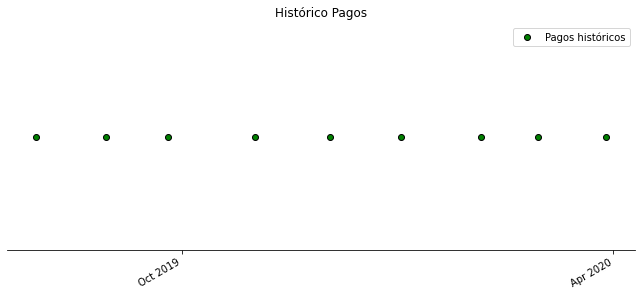

In [14]:
name_pay = ["pago "+str(i) for i in range(1, len(fecha_pago))]
levels = np.tile([5], int(np.ceil(len(fecha_pago)/6)))[:len(fecha_pago)]

# Create figure
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
# put title
ax.set(title="Histórico Pagos")
ax.plot(fecha_pago, np.zeros_like(fecha_pago), "ro",
        color="k", markerfacecolor="g", label="Pagos históricos")  

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.legend()

La intención del programa será predecir en que fecha se realizará el siguiente pago, en simples terminos, en que momento del tiempo se ubicará el siguiente punto verde. Sin embargo aún faltan anotar todas las fechas completas para conmesurar y tener los datos de cada cuanto se hace el pago. Se crea un vector que contenga todos lops días desde el inicio del primer pago, hasta el ultimo registrado 

In [15]:
first_pay = fecha_pago.min()
last_pay  = fecha_pago.max() 
time_product = pd.date_range(first_pay, last_pay)
print("Dias de vida del producto = {}".format(len(time_product)))
print("Pago hechos = {}".format(len(fecha_pago)))

Dias de vida del producto = 243
Pago hechos = 9


para poder evidenciar el pago, se debe crear un vector que registre cuando se hizo el pago y cuando no para tener claridad. Esto se hace creando un vector lleno de ceros y nada mas asigando uno cuando se tenga una fecha de pago. Adicional a esto se hace un mapeo de la fechas a un vector de etiquetas, es decir, se crea un vector alternativo que registra las fechas con numeros. Por ejemplo a la primera fecha registrada se le asigna el valor 1, a la siguiente el 2 y asi sucesivamente hasta completar los d'ias registrados en la base de datos 

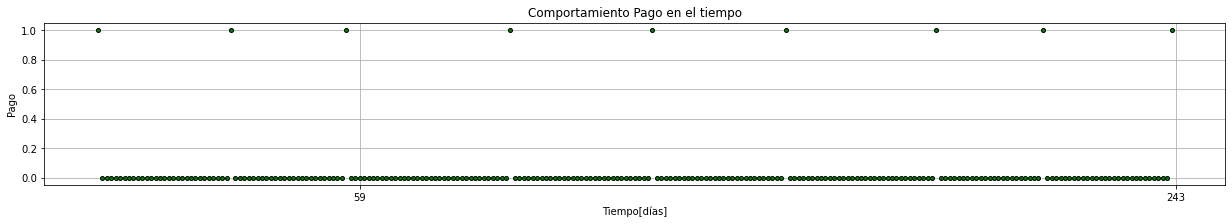

In [16]:
# vector de ceros 
pagos = np.zeros(len(time_product))
#vector de etiqueta de tiempo 
labels_time = np.arange(len(time_product))
# se identifican las fechas de pago dentro del vector de tiempo de vida del producto
for i in range(len(fecha_pago)):
    index_to_replace = np.where(time_product == fecha_pago.iloc[i])
    pagos[index_to_replace] = 1

fig, ax = plt.subplots(figsize=(17, 3), constrained_layout=True)
ax.set(title="Comportamiento Pago en el tiempo")
ax.plot(labels_time, pagos, "ro", color="k", markerfacecolor="g", markersize=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.set_xlabel("Tiempo[días]")
ax.set_ylabel("Pago")
plt.grid(True)

En el orden de hacer la predicción se quiere hacer un forecasting de una serie de tiempo binaria, que me prediga el dia siguiente de pago teniendo en cuenta toda la historia anterior del comportamiento de este producto, respecto del día cero del producto. Para poder hacer testeo se requiere separar los últimos 30 días de pago como conjunto de validación. 

In [17]:
test_size = 90

labels_time_train = labels_time[:-test_size]
pagos_train = pagos[:-test_size]
labels_time_test = labels_time[-test_size:]
pagos_test = pagos[-test_size:]

# Regresión con redes neuronales LSTM (Long Short-Term Memory Network)

Tipo de red neuronal recurrente capaz de recordar la información pasada al predecir valores futuros, este tipo de arquitectura tiene en cuenta la información pasada. Mantiene un estado global que se mantiene en todas als entradas. Todo el contexto de la entrada anterior es básicamente transferido a entradas futuras por un estado global, esto hace que no sufa problemas de valores perdidos y inestabilidades numéricas.

Veamos la decodificación ...

<img src="decodificacion.png"> 

* __Estado de celda:__ Se define como la capa de memoria que contiene el contexto del problema a través de las entradas 

* __Estado oculto:__ Capa de alimentación de salida de una capa anterior a una entrada más nueva

* __Puerta de olvido:__ Decide si debido a la nueva $X$, debemos eliminar la memoria anterior de la red. Por ejemplo; "Andrés es un niño. Andrea es una niña".  Cuando se alimente el modelo con "Andrea" como entrada, se debe olvidar el contexto previo que se tenía sobre "Andrés".

* __Puerta de entrada:__ Decide si debido a la nueva X, debemos actualizar la memoria anterior de la red

* __Puerta de salida:__ Cada entrada debe dar una salida basada en la entrada actual, la salida de la capa anterior y la celda de la memoria persistente

Este esquema presenta la red Neuronal resumida

<img src="decodificacion.png"> 

* __Puerta de olvido(cuadro amarillo):__ 

$$F=\sigma(u_{1}X + \omega_{1}\hat{H})$$

Para iniciar se debe tener en cuenta que en un problema de series temporales se tiene que predecir un valor en el tiempo $t$, basado en los días pasados $tN$ donde $N$ puede ser cualquier número de pasos. Se va a predecir el día de pago. Se van a probar diferentes pasos de tiempos para tratar de construir el mejor modelo posible.

Se crea entonces los conjuntos de datos necesarios para entrenar el modelo. El conjunto de características debe contener los valores 



In [18]:
features_set = list()
labels = list()

Nt = len(pagos_train)- test_size

for i in range(Nt, len(pagos_train)):
    features_set.append(pagos_train[i-Nt:i])
    labels.append(pagos_train[i])

features_set, labels = np.array(features_set), np.array(labels)
features_set.shape

(90, 63)

Para entrenar la red LSTM a pattir de estos datos, se necesita convertir los datos a una forma que la red Neuronal entienda. Esto es un tensor , un formato de matrices tridimensional. La primera dimensión es el número de registros o filas en el conjunto de datos 

In [19]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape

(90, 63, 1)

Se han redimensionado los datos, en este momento se propone el modelo LSTM. El modelo que se va a crear es un modelo secuencial con múltiples capas, en principio se agregan cuatro capas LSTM al modelo seguida de una capa densa que predice el día futuro de pago.

In [20]:
model = Sequential()
model.add(LSTM(units=1, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=2, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=7, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=15, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation="sigmoid"))

Ahora se compila el modelo, Se utiliza como función de pérdida el error medio cuadrado

$$ECM = \frac{1}{n}\sum^{n}_{i=1}(\hat{y}_{i}-y_{i})$$


In [21]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])


Ahora es el momento del entrenamiento del modelo que se definió anteriormente. Se hace una prueba para ver que tanto se demora el modelo 

In [22]:
model.fit(features_set, labels, epochs = 10, batch_size = 64)


Epoch 1/10
90/90 [==============================] - 5s 60ms/step - loss: 0.6915 - accuracy: 0.5333
Epoch 2/10
90/90 [==============================] - 1s 7ms/step - loss: 0.6797 - accuracy: 0.9778
Epoch 3/10
90/90 [==============================] - 1s 7ms/step - loss: 0.6656 - accuracy: 0.9778
Epoch 4/10
90/90 [==============================] - 1s 7ms/step - loss: 0.6480 - accuracy: 0.9778
Epoch 5/10
90/90 [==============================] - 1s 7ms/step - loss: 0.6255 - accuracy: 0.9778
Epoch 6/10
90/90 [==============================] - 1s 7ms/step - loss: 0.5957 - accuracy: 0.9778
Epoch 7/10
90/90 [==============================] - 1s 7ms/step - loss: 0.5502 - accuracy: 0.9778
Epoch 8/10
90/90 [==============================] - 1s 7ms/step - loss: 0.4960 - accuracy: 0.9778
Epoch 9/10
90/90 [==============================] - 1s 7ms/step - loss: 0.4191 - accuracy: 0.9778
Epoch 10/10
90/90 [==============================] - 1s 7ms/step - loss: 0.3387 - accuracy: 0.9778


Una vez entrenado el modelo LSTM, es el momento de probar el rendimiento de nuestro algoritmo en el conjunto de prueba al predecir los precios de pago en el siguiente mes, es decir, 30 días después del último día registrado en el conjunto de entrenamiento. Para cada día del mes siguiente que queremos predecir se debe tener los 120 días anteriores. Entonces se deben concatenar los datos de validación y de entrenamiento. 

Es importante anotar que para esta etapa de desarrollo se tienen los datos consignados en las variables iniciales de lectura, de otra manera si se tienen datos de testeo independientes se deben concatenar para tener el conjunto de datos completo y poder hacer la preparación adecuadoa para someter al modelo.

Ahora se prepara las entradas al modelo de prueba. La entrada para cada día debe contener los datos de pago de 120 días anteriores y los 30 datos para la predicción, se constuye el vector con estos 150 valores

In [23]:
test_inputs = pagos[len(pagos) - len(pagos_test) - Nt:]
test_inputs = test_inputs.reshape(-1,1)


Finalmente se prepara el conjunto de entrada del modelo de prueba final que contendrá los $Nt$ días anteriores del histórico para los siguientes 90 días.

In [24]:
test_features = list()
for i in range(Nt, Nt+test_size):
    test_features.append(test_inputs[i-Nt:i])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

Ahora se hace la predicción de los datos prueba 

In [25]:
predictions = model.predict_proba(test_features)

Se hace una grafica que resuma las predicciones en 90 días y que clarifique las fechas que el modelo está haciendo predicción para los días mencionados anteriormente. 

Última fecha de fago registrada = 2020-03-29


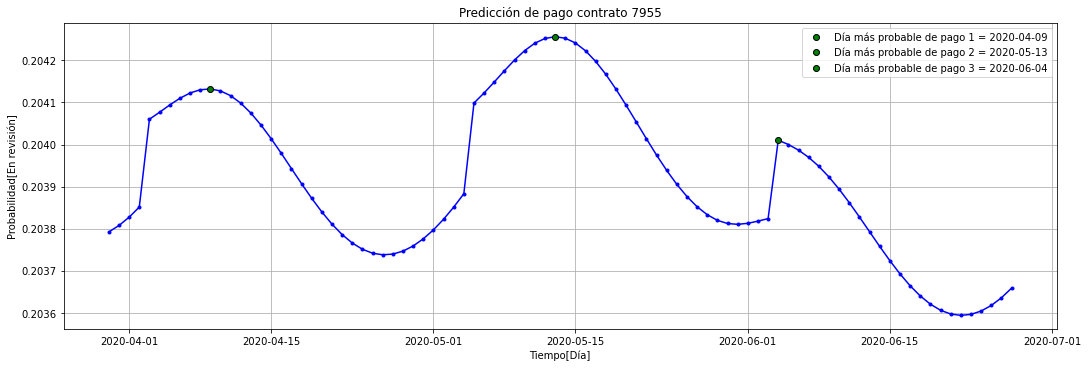

In [26]:
fechas = time_product[-test_size:] + timedelta(days=test_size)
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
plt.plot(fechas, predictions, "b-")
plt.plot(fechas, predictions, "b.")

if test_size == 30:
    day1 = np.argmax(predictions[:30])
    plt.plot(fechas[day1], predictions[day1], "ro",label = "Día más probable de pago 1 = {}".format(fechas[day1]),
        color="k", markerfacecolor="g")
if test_size == 60:
    day1 = np.argmax(predictions[:30])
    day2 = np.argmax(predictions[31:-1]) + 30
    plt.plot(fechas[day1], predictions[day1], "ro",label = "Día más probable de pago 1 = {}".format(fechas[day1]),
        color="k", markerfacecolor="g")
    plt.plot(fechas[day2], predictions[day2], "ro",label = "Día más probable de pago 2 = {}".format(fechas[day2]),
        color="k", markerfacecolor="g")
if test_size == 90:
    day1 = np.argmax(predictions[:30])
    day2 = np.argmax(predictions[30:60]) + 30
    day3 = np.argmax(predictions[60:-1]) + 60
    plt.plot(fechas[day1], predictions[day1], "ro",label = "Día más probable de pago 1 = {}".format(fechas[day1].date()),
        color="k", markerfacecolor="g")
    plt.plot(fechas[day2], predictions[day2], "ro",label = "Día más probable de pago 2 = {}".format(fechas[day2].date()),
        color="k", markerfacecolor="g")
    plt.plot(fechas[day3], predictions[day3], "ro",label = "Día más probable de pago 3 = {}".format(fechas[day3].date()),
        color="k", markerfacecolor="g")
    
plt.title("Predicción de pago contrato "+str(int(producto_x)))
plt.xlabel("Tiempo[Día]")
plt.ylabel("Probabilidad[En revisión]")
plt.grid(True)
plt.legend()
print("Última fecha de fago registrada = {}".format(data[data["ID_CONTRATO"]==producto_x]["FECHA_PAGO"].max().date()))

Se hace evidente que el modelo trata de capturar el comportamiento histórico del modelo. Sin embargo no se tiene generalidad al momento de encontrar máximos en esta predicción, por esta razón se hace necesario construir una rutina que encuentre los máximos locales.


Última fecha de fago registrada = 2020-03-29


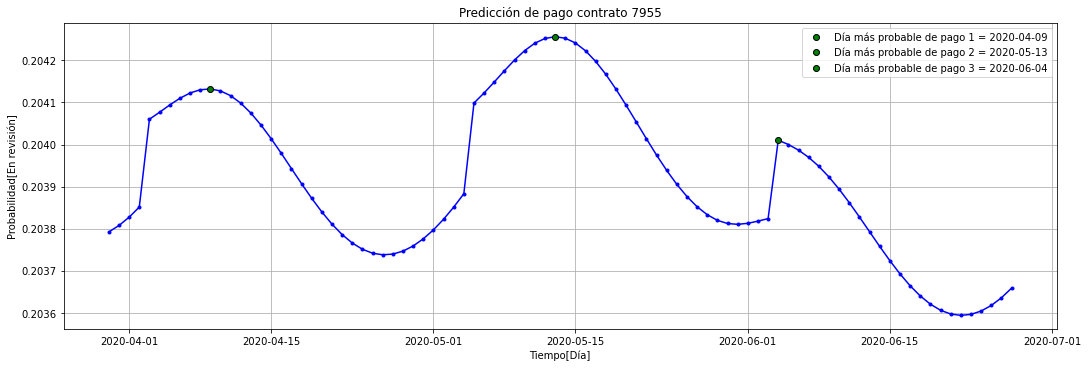

In [27]:
fechas = time_product[-test_size:] + timedelta(days=test_size)
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)

ind_max = argrelextrema(predictions, np.greater)[0]

prefix = "Día más probable de pago {} = "
prefix_date = [ prefix.format(i+1) for i in range(len(ind_max)) ]

plt.plot(fechas, predictions, "b-")
plt.plot(fechas, predictions, "b.")
for i in range(len(ind_max)):
    plt.plot(fechas[ind_max[i]], predictions[ind_max[i]], "ro",label=prefix_date[i]+ "{}".format(fechas[ind_max[i]].date()),
        color="k", markerfacecolor="g")

plt.title("Predicción de pago contrato "+str(int(producto_x)))
plt.xlabel("Tiempo[Día]")
plt.ylabel("Probabilidad[En revisión]")
plt.grid(True)
plt.legend()
print("Última fecha de fago registrada = {}".format(data[data["ID_CONTRATO"]==producto_x]["FECHA_PAGO"].max().date()))

Se hace una grafica de linea temporal para ver si la predicción está acorde al comportamiento a través del tiempo de vida del producto

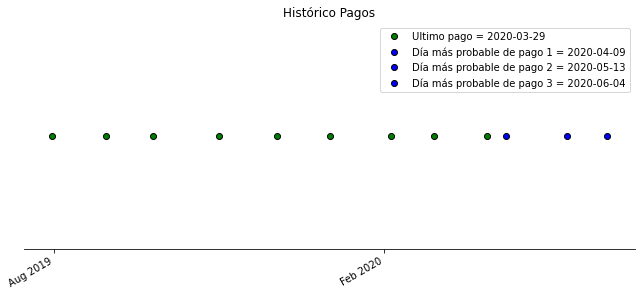

In [28]:
# Create figure
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
# put title
ax.set(title="Histórico Pagos")
ax.plot(fecha_pago, np.zeros_like(fecha_pago), "ro",
        color="k", markerfacecolor="g", label="Ultimo pago = {}".format(data[data["ID_CONTRATO"]==producto_x]["FECHA_PAGO"].max().date())) 


for i in range(len(ind_max)):
    ax.plot(fechas[ind_max[i]], np.zeros_like(fechas[ind_max[i]]), "ro",label=prefix_date[i]+ "{}".format(
        
        fechas[ind_max[i]].date()),
        color="k", markerfacecolor="b")


#ax.plot(fechas[day1], np.zeros_like(fechas[day1]), "ro",
#        color="k", markerfacecolor="b", label="Predicción 1 = {}".format(fechas[day1].date())) 
#ax.plot(fechas[day2], np.zeros_like(fechas[day2]), "ro",
#        color="k", markerfacecolor="b", label="Predicción 2 = {}".format(fechas[day2].date()))
#ax.plot(fechas[day3], np.zeros_like(fechas[day3]), "ro",
#        color="k", markerfacecolor="b", label="Predicción 3 = {}".format(fechas[day3].date()))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.legend()

Sin embargo aún no se sabe lo que para el algoritmo es un buen cliente, y se definira entonces en relación a la idea de un pago periodico. Para esto se propone utilizar el error cuadratico medio, que es la raíz cuadrada de la media del cuadrado de todos los errores. 

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\hat{y}_{i}-y_{i})^{2}}$$

en donde $\hat{y}_{i}$ es la observación verdadera y $y_{i}$ es la predición, veamos el calculo del RMSE para un determinado cliente


In [29]:
# Creacion de la fecha de pago sintética, es decir para esto se hace un vector de pagos periódicos tomando como referencia la primera fecha de pago del producto
# y creando un vector de tamaño iguak que el tiempo de vida del producto 
first_pay = fecha_pago.min()
last_pay  = fecha_pago.max()
yhat = pd.date_range(fecha_pago.min(), periods=len(fecha_pago), freq="M") -timedelta(days=8)
# se debe organizar los datos de menor a mayor antigüedad
y = fecha_pago.sort_values()
n = len(y)

def RMSE(yhat, y):
    return np.sqrt((1/n)*(int(np.sum((yhat-y)).days))**2)

puntaje_cleinte = RMSE(yhat, y)
puntaje_perfecto = RMSE(yhat, yhat)
puntaje_buencliente = RMSE(yhat, yhat + timedelta(days=5))

aux_date_range = pd.date_range(fecha_pago.min(), periods=len(fecha_pago)+3, freq="M").min().day
yhat_pred = pd.date_range(fecha_pago.min(), periods=len(fecha_pago)+3, freq="M") -timedelta(days=aux_date_range-fecha_pago.min().day)
add_pagos = fecha_pago.sort_values()
predicted_days = pd.Series([fechas[day1], fechas[day2], fechas[day3]])
y_pred = add_pagos.append(predicted_days, ignore_index=True)

puntaje_predicho = RMSE(yhat_pred, y_pred)
print("Cliente perfecto = {:.0f}".format(puntaje_perfecto))
print("Buen cliente = {:.0f}".format(puntaje_buencliente))
print("Puntaje cliente = {:.0f}".format(puntaje_cleinte))
print("Puntaje_predicho = {:.0f}".format(puntaje_predicho))

if puntaje_predicho > puntaje_cleinte:
    
    print("El producto {} desmejorará su política de pago".format(producto_x))

    port = 587  
    smtp_server = "smtp.outlook.com"
    sender_email = "johan.mendez@databiz.co"  
    receiver_email = "jsmendezh@unal.edu.co" 
    password = "Databiz123@"

    message = """\
    Subject: Aviso Pago

    El Contrato {} segun la predicion del modelo va hacer pagos de la siguiente manera 

    Dia mas probable de pago 1 = {}

    Dia mas probable de pago 2 = {}

    """.format(int(producto_x), fechas[ind_max[0]].date(),fechas[ind_max[1]].date())

    context = ssl.create_default_context()
    print("contexto creado")
    with smtplib.SMTP(smtp_server, port) as server:
        server.ehlo()  # Can be omitted
        print("Empezando contexto")
        server.starttls(context=context)
        server.ehlo()  # Can be omitted
        print("Autenticando ...")
        server.login(sender_email, password)
        print("Enviando ...")
        server.sendmail(sender_email, receiver_email, message)

Cliente perfecto = 0
Buen cliente = 15
Puntaje cliente = 25
Puntaje_predicho = 21


Entonces si el puntaje del cliente aumenta es candidato a contactarlo a través del canal de comunicación estipulado por la entidad

# Inclusión de la información del cliente

En primer lugar lo que se quiere ver es la distribución de productos por clientes, para esto se debe hacer una lista auxiliar que permita saber por cliente cuantos productos se tiene. y hacer un histograma que permita ver la estadística.


In [30]:
# Creacion de la lista que va a almacenar la frecuencia
dist_product = []
# ciclo que verifica cada cliente
N_clientes = len(data["ID_CLIENTE"].unique())

for cliente in range(N_clientes):
    n_contratos = len(data["ID_CONTRATO"][(data["ID_CONTRATO"] != np.nan) & (data["ID_CLIENTE"] == data["ID_CLIENTE"].iloc[cliente] )].unique())
    dist_product.append(n_contratos)

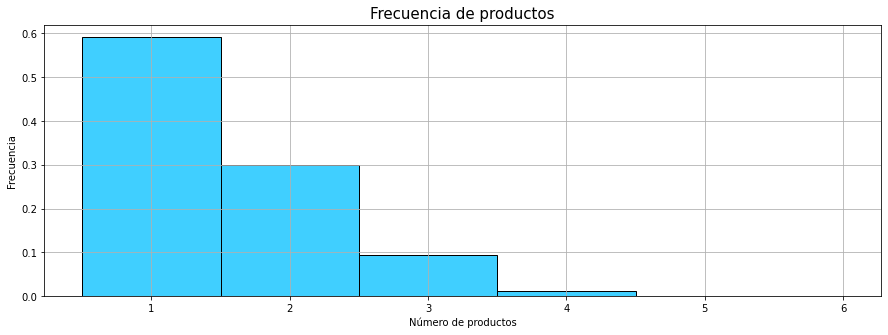

In [68]:
fig, ax = plt.subplots(figsize = (15,5))

sns.histplot(dist_product,stat="probability", color='deepskyblue', binwidth=0.5, shrink=2)

plt.title('Frecuencia de productos', size=15)
plt.xlabel("Número de productos")
plt.ylabel("Frecuencia")
plt.tick_params(left=True, bottom=True)
plt.grid(True)

La distribución de los clientes que tienen cuentas sigue una distribución de pareto, la mayoría de clientes tiene solamente una cuenta, sin embargo, se evidencia que existe tambien un grupo de clientes considerables que tienen dos productos. En orden de refinar el algoritmo en la predicción de pago se hace mucho más importante predecir que los clientes que tengan más de una cuenta, dado que si un cliente que tenga cuatro productos, por ejemplo, desmoejora en un producto su pago es problable que esto repercuta en los otros productos del banco. Para esto los que se propone como primer modelo será hacer uns arquitectura de redes neuronales gemelas.

Como primer paso se debe elegir un cliente y ver los productos asociados, para poder evidenciar su comportamiento de pago 

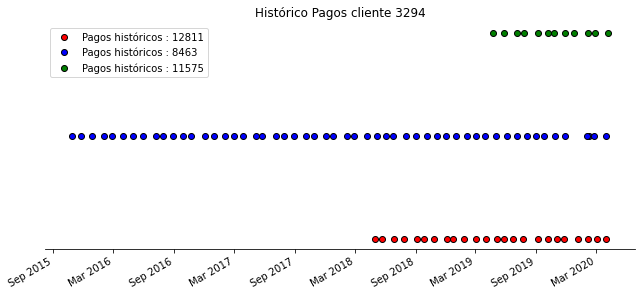

In [155]:
cliente = 3294

#for i in range(N_clientes):
n_contratos = len(data["ID_CONTRATO"][(data["ID_CONTRATO"] != np.nan) & (data["ID_CLIENTE"] == cliente )].unique())
contratos = data["ID_CONTRATO"][(data["ID_CONTRATO"] != np.nan) & (data["ID_CLIENTE"] == cliente )].unique()
fecha_pago_contrato = []

for i in range(n_contratos):  
    fecha_pago_contrato.append(pd.to_datetime(data["FECHA_PAGO"][data["ID_CONTRATO"]==contratos[i]]))
    
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Histórico Pagos cliente {}".format(cliente))

color = [ "red", "blue", "green", "yellow", "purple", "orange"]

for i in range(n_contratos):
    ax.plot(fecha_pago_contrato[i], i+np.zeros_like(fecha_pago_contrato[i]), "ro",
        color="k", markerfacecolor=color[i], label="Pagos históricos : {}".format(int(contratos[i])))
    
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.legend()
    

A simple vista no se puede tener alguna correlación evidente para estas series temporales, antes de plantear alguna estadística se hace la binarización de los contratos asociados al cliente para poder establecer una comparación objetiva

In [156]:
def jaccard_similarity(x1, x2):
    s1 = set(x1)
    s2 = set(x2)
    
    return float(len(s1.intersection(s2))/len(s1.union(s2)))
    

Para tener una comparación objetiva de las "similitudes" básicamente , la serie puede pensarse como un efecto a observar en un rango $i = 1,2,\dots, n$. como variables aleatorias de Bernoulli no idénticamente distribuidas y posiblemente dependientes

$$Y_{i}\sim \mathcal{B}(\pi_{i})$$

donde $\pi_{i}$ es una probabilidad de éxito que cambia con el tiempo y puede depender de algunos factores externos, correlacionarse automáticamente